This code estimates the heating of a parcel of air that is affected by dendritic ice crystal nucleation around -15C and with a constant supply of humidity that keeps supersaturation constant

We start by setting some constants

In [1]:
%matplotlib inline 
from meteoSI import g, Rair, Rvapor, Cp, Tnull, T_virt_rh, moist_rho_rh
Cw = 4182. # specific heat of water J/K/kg
Ci = 2093. # specific heat of ice J/K/kg
Lc = 2.501e6 # latent heat of condensation J/kg
Ls = 2.834e6 # latent heat of sublimation J/kg
Lf = Ls - Lc # latent heat of fusion

The the parameter settings

In [2]:
p = 700e2 # pressure [Pa]
T = -Tnull - 15. # temperature [K]
rh = 1.1 # relative humidity [Pa/Pa]
q_hydro = 0. # mixing ratio of hydrometeors (contributing to air density) [kg/kg] NOT USED SO FAR
Nt = 10e5 # Number of particles per cubic meter

v0 = 0.0 # initial (large scale) air parcel vertical velocity [m/s]
Tstop = 1800 # stop simulation time [seconds]
dt = 0.001 # time step of the Euler scheme [s]

Tv = T_virt_rh(T, rh, p)
rho_a = moist_rho_rh(p, T, rh, q_hydro)

Ice crystal growth rate, visually extrapolated at a temperature of -15C from Fig.4 of Fukuta and Takahashi 1999. The numbers are valid for p=1010 hPa and LWC=0.1 gm-3, but the measurements for p=860 hPa and LWC=0.5 gm-3 appear to be very similar in the dendritic growth zone.

/work/develop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


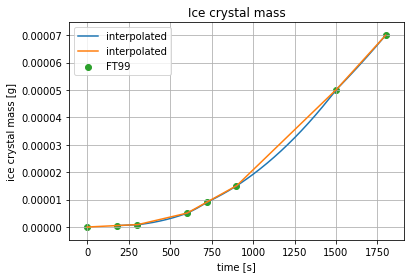

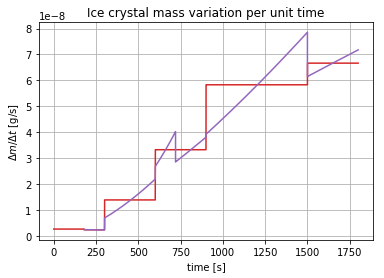

In [3]:
import numpy as np
import matplotlib.pyplot as plt
time = np.array([0., 3, 5, 10, 12, 15, 25, 30])*60. # seconds
mass = np.array([0.,.5, .8,  5, 9, 15, 50, 70])*1e-6 # grams

t = np.arange(0.,Tstop, dt)
m1 = np.power(10.0, np.interp(np.log10(t), np.log10(time), np.log10(mass)))
m = np.interp(t, time, mass)

plt.plot(t,m1,'C0', label='interpolated')
plt.plot(t,m,'C1', label='interpolated')
plt.scatter(time, mass, c='C2', label='FT99')
plt.xlabel('time [s]')
plt.ylabel('ice crystal mass [g]')
plt.title('Ice crystal mass')
plt.legend()
plt.grid()
plt.show()

dm = m[1:]-m[:-1]
dm1 = m1[1:]-m1[:-1]
plt.plot(t[1:], dm/dt, 'C3')
plt.plot(t[1:], dm1/dt, 'C4')
plt.title('Ice crystal mass variation per unit time')
plt.xlabel('time [s]')
plt.ylabel('$\Delta m / \Delta t$ [g/s]')
plt.grid()
plt.show()


Apply a simple Euler scheme to estimate temperature evolution

In [4]:
dM = dm*Nt/dt # mass of ice condensed from vapour per second in a cubic meter [g m-3 s-1]
dQv = 1e-3*dM*Ls # Heat released per second in a cubic meter due to ice condensation [J m-3 s-1]
dQm = dQv/rho_a # Same as above, but for 1 kg of air [J kg-1 s-1]
dTemp = dQm/Cp # temperature variation due to air heating [K s-1]
Temp = T + dTemp.cumsum()*dt # temperature evolution over time [K]

Now we assume ambient temperature beeing constant while the air parcel raises

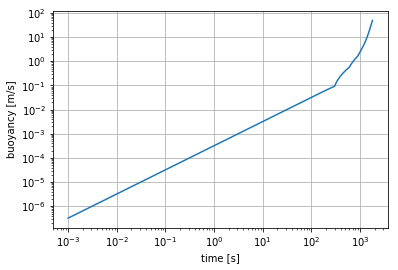

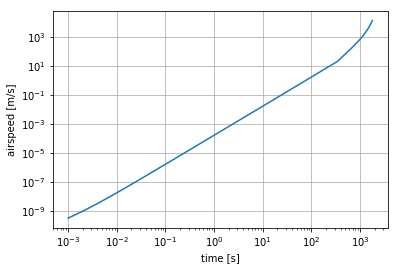

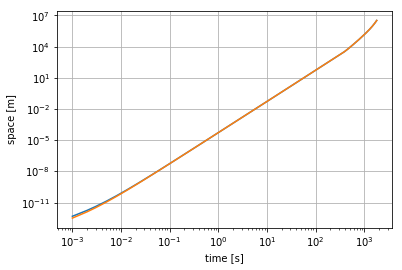

48.80074510248998 12761.81669094522 3334208.712552653


In [5]:
Tvp = T_virt_rh(Temp, rh, p) # evolution of virtual temperature [K]
ab = -g*(Tv-Tvp)/Tvp # evolution of buoyant acceleration [m s-2]
v = v0 + ab.cumsum()*dt # evolution of speed [m s-1]
s = 0.0 + v.cumsum()*dt + 0.5*ab.cumsum()*dt*dt # evolution of space [m]
s1 = v.cumsum()*dt # evolution of space [m]

plt.loglog(t[1:], ab)
plt.xlabel('time [s]')
plt.ylabel('buoyancy [m/s]')
plt.grid()
plt.show()

plt.loglog(t[1:], v)
plt.xlabel('time [s]')
plt.ylabel('airspeed [m/s]')
plt.grid()
plt.show()

plt.loglog(t[1:], s)
plt.loglog(t[1:], s1)
plt.xlabel('time [s]')
plt.ylabel('space [m]')
plt.grid()
plt.show()
print(ab[-1], v[-1], s[-1])